In [1]:
!pip install  pyepics
!pip install  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [62]:
%matplotlib notebook
import numpy as np
import time
import pandas as pd
from os import putenv
from epics import PV
import ipywidgets as widgets
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation


mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = "both"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams["legend.loc"] = 'upper right'
np.set_printoptions(suppress=True)

In [63]:
from model.model import Model as Model81

In [64]:
putenv('EPICS_CA_ADDR_LIST', 'laser-north.dhcp.lbl.gov')
putenv('EPICS_CA_AUTO_ADDR_LIST', 'NO')

doe = np.load('model/doe.npy')
p_doe = np.angle(doe, deg=True)

In [96]:
pv_slm = {}
pv_cam = {}

def xy2ij(x, y, center=4):
    i = center - y
    j = x + center
    return i, j

def ij2xy(i, j, center=4):
    x = j - center
    y = center - i    
    return x, y

for i in range(9):
    for j in range(9):
        x, y = ij2xy(i, j)
        d = {}
        d['amp'] = PV('SLM:AmpControl:{:1d}_{:1d}'.format(i,j))
        d['phs'] = PV('SLM:PhsControl:{:1d}_{:1d}'.format(i,j))
        d['enable'] = PV('SLM:Enable:{:1d}_{:1d}'.format(i,j))
        d['phs_out'] = PV('SLM:PhsOut:{:1d}_{:1d}'.format(i,j))
        d['phs_slope'] = PV('SLM:PhsSlope:{:1d}_{:1d}'.format(i,j))
        d['phs_offset'] = PV('SLM:PhsOffset:{:1d}_{:1d}'.format(i,j))    
        pv_slm[(x,y)] = d

pv_cam['array'] = PV('North:Camera:Far:Array')
pv_cam['center'] = PV('North:Camera:Far:Center')
pv_cam['side'] = PV('North:Camera:Far:Side')
pv_cam['sum'] = PV('North:Camera:Far:Sum')
pv_cam['contrast'] = PV('North:Camera:Far:Contrast')
pv_cam['eff'] = PV('North:Camera:Far:Efficiency')

In [97]:
pv_slm[(0,0)]['enable']

<PV 'SLM:Enable:4_4', count=1, type=time_enum, access=read/write>

# 9x9 DOE combining simulation:

### Optimal 81 beam phase:

<IPython.core.display.Javascript object>


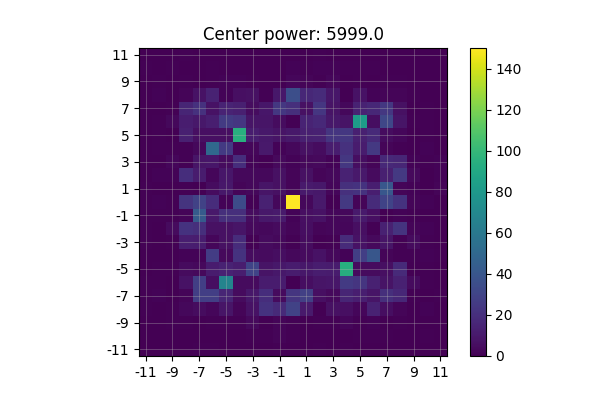

In [84]:
model = Model81()
power_sim = model.ideal_s_power
N = power_sim.shape[0]
ticks = np.arange(0, N, 2)
ticks_label = ticks - N//2

fig, ax = plt.subplots()
im = ax.imshow(power_sim, vmax=150);
ax.set_title('Center power: {:.1f}'.format(power_sim[N//2,N//2]))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks_label)
ax.set_yticklabels(ticks_label[::-1])
fig.colorbar(im, ax=ax);

# 9x9 combining Experiment:

In [98]:
def wrap_ph(phases, deg=True):
    if deg:
        return (phases + 180) % 360 - 180
    else:
        return (phases + np.pi) % (2 * np.pi) - np.pi

def toggle_all(on=False):
    for x in range(-4, 5):
        for y in range(-4, 5):
            pv_slm[(x,y)]['enable'].put(on)

def get_ena_arr():
    enable_status = np.empty((9,9))
    for x in range(-4, 5):
        for y in range(-4, 5):
            i, j = xy2ij(x, y)
            enable_status[i,j] = pv_slm[(x,y)]['enable'].value
    return enable_status

def format_ticks(ax, N):
    ticks = np.arange(0, N, 2)
    ticks_label = ticks - N//2
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks_label)
    ax.set_yticklabels(ticks_label[::-1])

### Interactive control widgets:

In [99]:
def on_change(label, enable, amp, phs):
    x, y = label.split()
    pv = pv_slm[(int(x), int(y))]
    pv['enable'].put(enable)
    pv['amp'].put(amp)
    pv['phs'].put(phs)
  
    
def create_3x3(amp_arr, phs_arr, off_x=0, off_y=0):
    grid = widgets.GridspecLayout(3, 3)

    for i in range(3):
        for j in range(3):
            x = j - 4 + off_x
            y = 4 - i - off_y
            label = widgets.Label(value='{} {}'.format(x, y))
            s1 = widgets.ToggleButton(
                description='({},{})'.format(x, y), value=False)
            s3 = widgets.FloatSlider(
                description='amp', min=0, max=1, step=0.002, readout_format='.3f', value=amp_arr[i,j])
            s4 = widgets.FloatSlider(
                description='phs', min=-180, max=180, step=1, value=phs_arr[i,j])
            out = widgets.interactive_output(
                on_change, {'label':label, 'enable': s1,'amp': s3, 'phs': s4})
            box_layout = widgets.Layout(border='solid 1px green', align_items='center')
            grid[i, j] = widgets.VBox([s1, s3, s4, out], layout=box_layout)
    return grid

## 81 beam combining with 6/27 settings

In [100]:
amp_man_blocks = np.empty((3,3,3,3))
phs_man_blocks = np.empty((3,3,3,3))
# left top
amp_man_blocks[0,0] = np.array([0.602, 0.466, 0.396, 0.588, 0.568, 0.406, 0.62, 0.618, 0.356]).reshape(3,3)
# left middle
amp_man_blocks[1,0] = np.array([0.64, 0.63, 0.31, 0.604, 0.648, 0.368, 0.566, 0.632, 0.416]).reshape(3,3)
# left bottom
amp_man_blocks[2,0] = np.array([0.516, 0.578, 0.408, 0.568, 0.528, 0.382, 0.9, 0.786, 0.46]).reshape(3,3)
# middle top
amp_man_blocks[0,1] = np.array([0.208, 0.154, 0.15, 0.186, 0.168, 0.16, 0.156, 0.166, 0.148]).reshape(3,3)
# middle middle
amp_man_blocks[1,1] = np.array([0.162, 0.174, 0.154, 0.200, 0.218, 0.184, 0.25, 0.27, 0.21]).reshape(3,3)
# middle bottom
amp_man_blocks[2,1] = np.array([0.278, 0.292, 0.228, 0.258, 0.236, 0.2, 0.234, 0.206, 0.19]).reshape(3,3)
# right top
amp_man_blocks[0,2] = np.array([0.128, 0.088, 0.066, 0.126, 0.078, 0.052, 0.116, 0.074, 0.05]).reshape(3,3)
# right middle
amp_man_blocks[1,2] = np.array([0.114, 0.074, 0.052, 0.128, 0.076, 0.052, 0.148, 0.076, 0.054]).reshape(3,3)
# right bottom
amp_man_blocks[2,2] = np.array([0.15, 0.078, 0.054, 0.15, 0.076, 0.064, 0.156, 0.098, 0.08]).reshape(3,3)

In [101]:
amp_man_blocks = np.ones((3,3,3,3)) * 0.8
# phs_man_blocks = np.empty((3,3,3,3))


## init phase

In [102]:
p_beam_deg = np.rad2deg(model.beam_phs)
ideal_ph_blocks = np.array([np.hsplit(m, 3) for m in np.vsplit(p_beam_deg, 3)])

In [103]:
ideal_ph_blocks[2,0]

array([[-141.,  -94.,  158.],
       [ -98.,   49.,  148.],
       [  20.,   76.,  -65.]])

In [104]:
blocks = []
titles = []
for off_x in range(3):
    for off_y in range(3):
        amp_arr = amp_man_blocks[off_y, off_x]
        phs_arr = ideal_ph_blocks[off_y, off_x]
        grid = create_3x3(amp_arr, phs_arr, off_x*3, off_y*3)
        blocks.append(grid)
        title = 'block ({},{})'.format(off_y, off_x)
        titles.append(title)

In [105]:
tab = widgets.Tab()
tab.children = blocks
tab.titles = titles
for i in range(len(tab.children)):
    tab.set_title(i, titles[i])

## Live data:

<IPython.core.display.Javascript object>


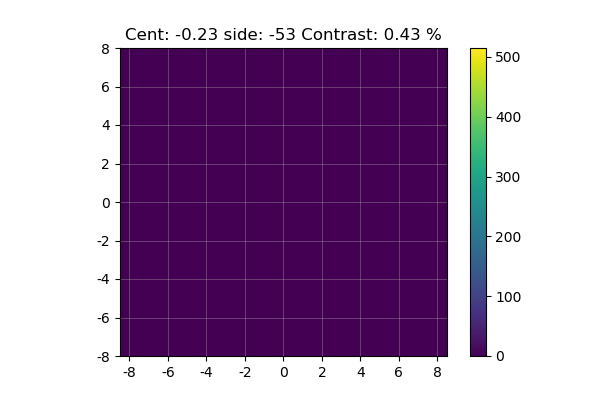

In [72]:
cam_arr = np.empty((17, 17))

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(cam_arr, animated=True, vmin=0, vmax=81)
title = ax.set_title('title')
format_ticks(ax, 17)
fig.colorbar(im, ax=ax)

def updatefig(*args):
    cam_arr = pv_cam['array'].value.reshape(17, 17)
    im.set_array(cam_arr)
#     im.set_clim(vmin=cam_arr.min(), vmax=cam_arr.max())
    im.set_clim(vmin=cam_arr.min(), vmax=515)
    side = pv_cam['side'].value
    cent = pv_cam['center'].value
    contrast = pv_cam['contrast'].value
    title.set_text(
        'Cent: {:4.2f} side: {:.0f} Contrast: {:4.2f} %'.format(
            cent, side, contrast * 100))
    return im,

anim = animation.FuncAnimation(fig, updatefig, interval=150, blit=True);

In [78]:
tab

## Turn on / off all beams

In [42]:
toggle_all(False)

In [106]:
toggle_all(True)

In [95]:
cam_arr = np.empty((17, 17))
enable_status = np.empty((9,9))

fig, axes = plt.subplots(1, 2, figsize=(9,3))
ax = axes[0]
en_im = ax.imshow(enable_status, vmin=0, vmax=1)
format_ticks(ax, 9)
ax.set_title('Input beams')

ax = axes[1]
im = ax.imshow(cam_arr, animated=True, vmin=0, vmax=81)
title = ax.set_title('title')
format_ticks(ax, 17)
fig.colorbar(im, ax=ax)

def updatefig(*args):
    en_im.set_array(get_ena_arr())
    cam_arr = pv_cam['array'].value.reshape(17, 17)
    im.set_array(cam_arr)
    im.set_clim(vmin=cam_arr.min(), vmax=cam_arr.max())
    side = pv_cam['side'].value
    total = pv_cam['sum'].value
    eff = pv_cam['eff'].value
    cent = pv_cam['center'].value
    contrast = pv_cam['contrast'].value
    title.set_text(
        'Cent: {:4.0f} side: {:.0f} Contrast: {:4.2f} %'.format(
            cent, side, contrast * 100))
    return im,

anim = animation.FuncAnimation(fig, updatefig, interval=150, blit=True);

<IPython.core.display.Javascript object>